In [1]:
!pip install torchmetrics
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 31.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import sys,os,torch
drive.mount('/content/drive')

path_stage_1 = r'/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_1_trained.pth'
path_stage_2 = r'/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_2_trained.pth'
path_stage_3 = r'/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_3_trained.pth'
root_path_data = '/content/drive/MyDrive/Vision Project/data_cityscape'
partitioned_data_root_path = '/content/drive/MyDrive/Vision Project/partitioned_data'
path_train_module = r'/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/'

# Setting device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


Mounted at /content/drive


In [3]:
sys.path.append(path_train_module)
from training_module import * # Do not try this at home


In [ ]:
model_stage_1 = load_model_correctly(path_stage_1, num_classes=20, load_heads=False, freeze_backbone=True)
model_stage_2 = load_model_correctly(path_stage_2, num_classes=20, load_heads=True, freeze_backbone=True)
model_stage_3 = load_model_correctly(path_stage_3, num_classes=20, load_heads=True, freeze_backbone=True)
val_loaders, val_datasets = load_data_loaders_and_datasets("val", partitions=4, batch_size=8, root_path=partitioned_data_root_path)


Now, we are performing hyperparameter tuning using 12.5 percent of the training data. We try to tune 4 critical parameters in RPN and ROIPooler: foregroung iou threshold (fg_iou_thresh), RPN positive IOU threshold (rpn_positive_iou_thresh), RPN negative IOU threshold (rpn_negative_iou_thresh) and whether to allow parameter updates in the Feature Pyramid Network (this hyperparameter is binary True or False).

In [ ]:
# The optuna trial function to be maximized. We try to maximize the mAP of the validation set that was reserved for hyperparameter tuning.



def objective(trial):
    try:

        fg_iou_thresh = trial.suggest_float("fg_iou_thresh", 0.3, 0.7)
        rpn_positive_iou_thresh = trial.suggest_float("rpn_positive_iou_thresh", 0.6, 0.9)
        rpn_negative_iou_thresh = trial.suggest_float("rpn_negative_iou_thresh", 0.1, 0.4)
        fpn_grad_flow = trial.suggest_categorical("fpn_grad_flow", [True, False])

        print('Loading model....')
        model_stage_1 = load_model_correctly(path_stage_1,num_classes=20, load_heads=False,freeze_backbone=True) #Loading the model after stage 1.



        model_optuna = get_model_for_tuning(
            model_stage_1 ,
            fg_iou_thresh,
            rpn_positive_iou_thresh,
            rpn_negative_iou_thresh,
            fpn_grad_flow
        )

        optimizer = torch.optim.AdamW(model_optuna.parameters(), lr=4e-5, weight_decay=0)
        tuning_hyperparams_dict["load_checkpoint"] = None
        tuning_hyperparams_dict["checkpoint_save_path"] =  '/content/sample_data'


        val_losses_extra, train_losses_extra, val_maps_extra = train_epoch_alpha_mixed_precision(
            model=model_optuna,
            optimizer=optimizer,
            device=device,
            **tuning_hyperparams_dict
        )

        return val_maps_extra[-1]

    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        return float('-inf')

# The hyperparameters that are staying fixed during the tuning.
tuning_hyperparams_dict = {
    "alpha": 0.9,                 # balances normal loss vs GIoU loss
    "iou_threshold": 0.45,              # standard for box matching
    "max_epochs": 5,                   # enough for convergence
    "patience": 5,                      # patience equals to training epochs - no early stopping used
    "root_path": partitioned_data_root_path,
    "train_partitions": 1,
    "val_partitions": [True, False, False, False],
    "batch_size": 4,                    # GPU memory safe
    "num_workers": 0,                   # parallel loading
    "cosine_t_max": 5,                 # cosine scheduler max epochs (same as max_epochs)
    "cosine_eta_min": 1e-5,             # minimum learning rate for cosine scheduler
    "cosine_last_epoch": -1,            # starting epoch for cosine scheduler
    "use_wandb": False,                 # set True if logging to wandb (not used)
    "pruning": False,                   # for Optuna pruning (not used)
    "trial": None,                      # for Optuna (not used)
    "checkpoint_save_path": "/content/drive/MyDrive/Vision Project/trained_models/final_checkpoints",
    "load_checkpoint": None,
    "validate_only_last":True # For faster trials.
}


In [ ]:
# Optuna hyperparam tuning
# Optuna creates a db file and updates it logging the trials it already have run.

# model_train = model_stage_2
study_save_path  = '/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/optuna_study.db'
study = optuna.create_study(direction="maximize",storage=f"sqlite:///{study_save_path}",study_name="trial",load_if_exists=True)
study.optimize(objective, n_trials=50, timeout=None)


[I 2025-08-28 22:45:00,149] Using an existing study with name 'trial' instead of creating a new one.


OPTUNA STUDY ANALYTICS - HYPERPARAMETER OPTIMIZATION RESULTS

📊 STUDY OVERVIEW:
   Study Name: trial
   Direction: MAXIMIZE
   Total Trials: 43
   Completed Trials: 42
   Pruned Trials: 0
   Failed Trials: 0

🏆 BEST TRIAL (Trial #29):
   Best Value (mAP): 0.2021
   Best Parameters:
      fg_iou_thresh: 0.415409
      rpn_positive_iou_thresh: 0.788944
      rpn_negative_iou_thresh: 0.219789
      fpn_grad_flow: True

📈 PERFORMANCE STATISTICS:
   Mean mAP: 0.1905
   Std mAP: 0.0041
   Best mAP: 0.2021
   Worst mAP: 0.1811
   Median mAP: 0.1906

🔥 TOP 5 TRIALS:
   #1 - Trial 29: mAP = 0.2021
   #2 - Trial 30: mAP = 0.1977
   #3 - Trial 26: mAP = 0.1969
   #4 - Trial 17: mAP = 0.1950
   #5 - Trial 27: mAP = 0.1950

🔧 HYPERPARAMETER RANGES:
   fg_iou_thresh:
      Range: [0.311357, 0.693334]
      Mean: 0.479647
   fpn_grad_flow: [np.True_, np.False_]
   rpn_negative_iou_thresh:
      Range: [0.110495, 0.398525]
      Mean: 0.278157
   rpn_positive_iou_thresh:
      Range: [0.602158, 0.8994

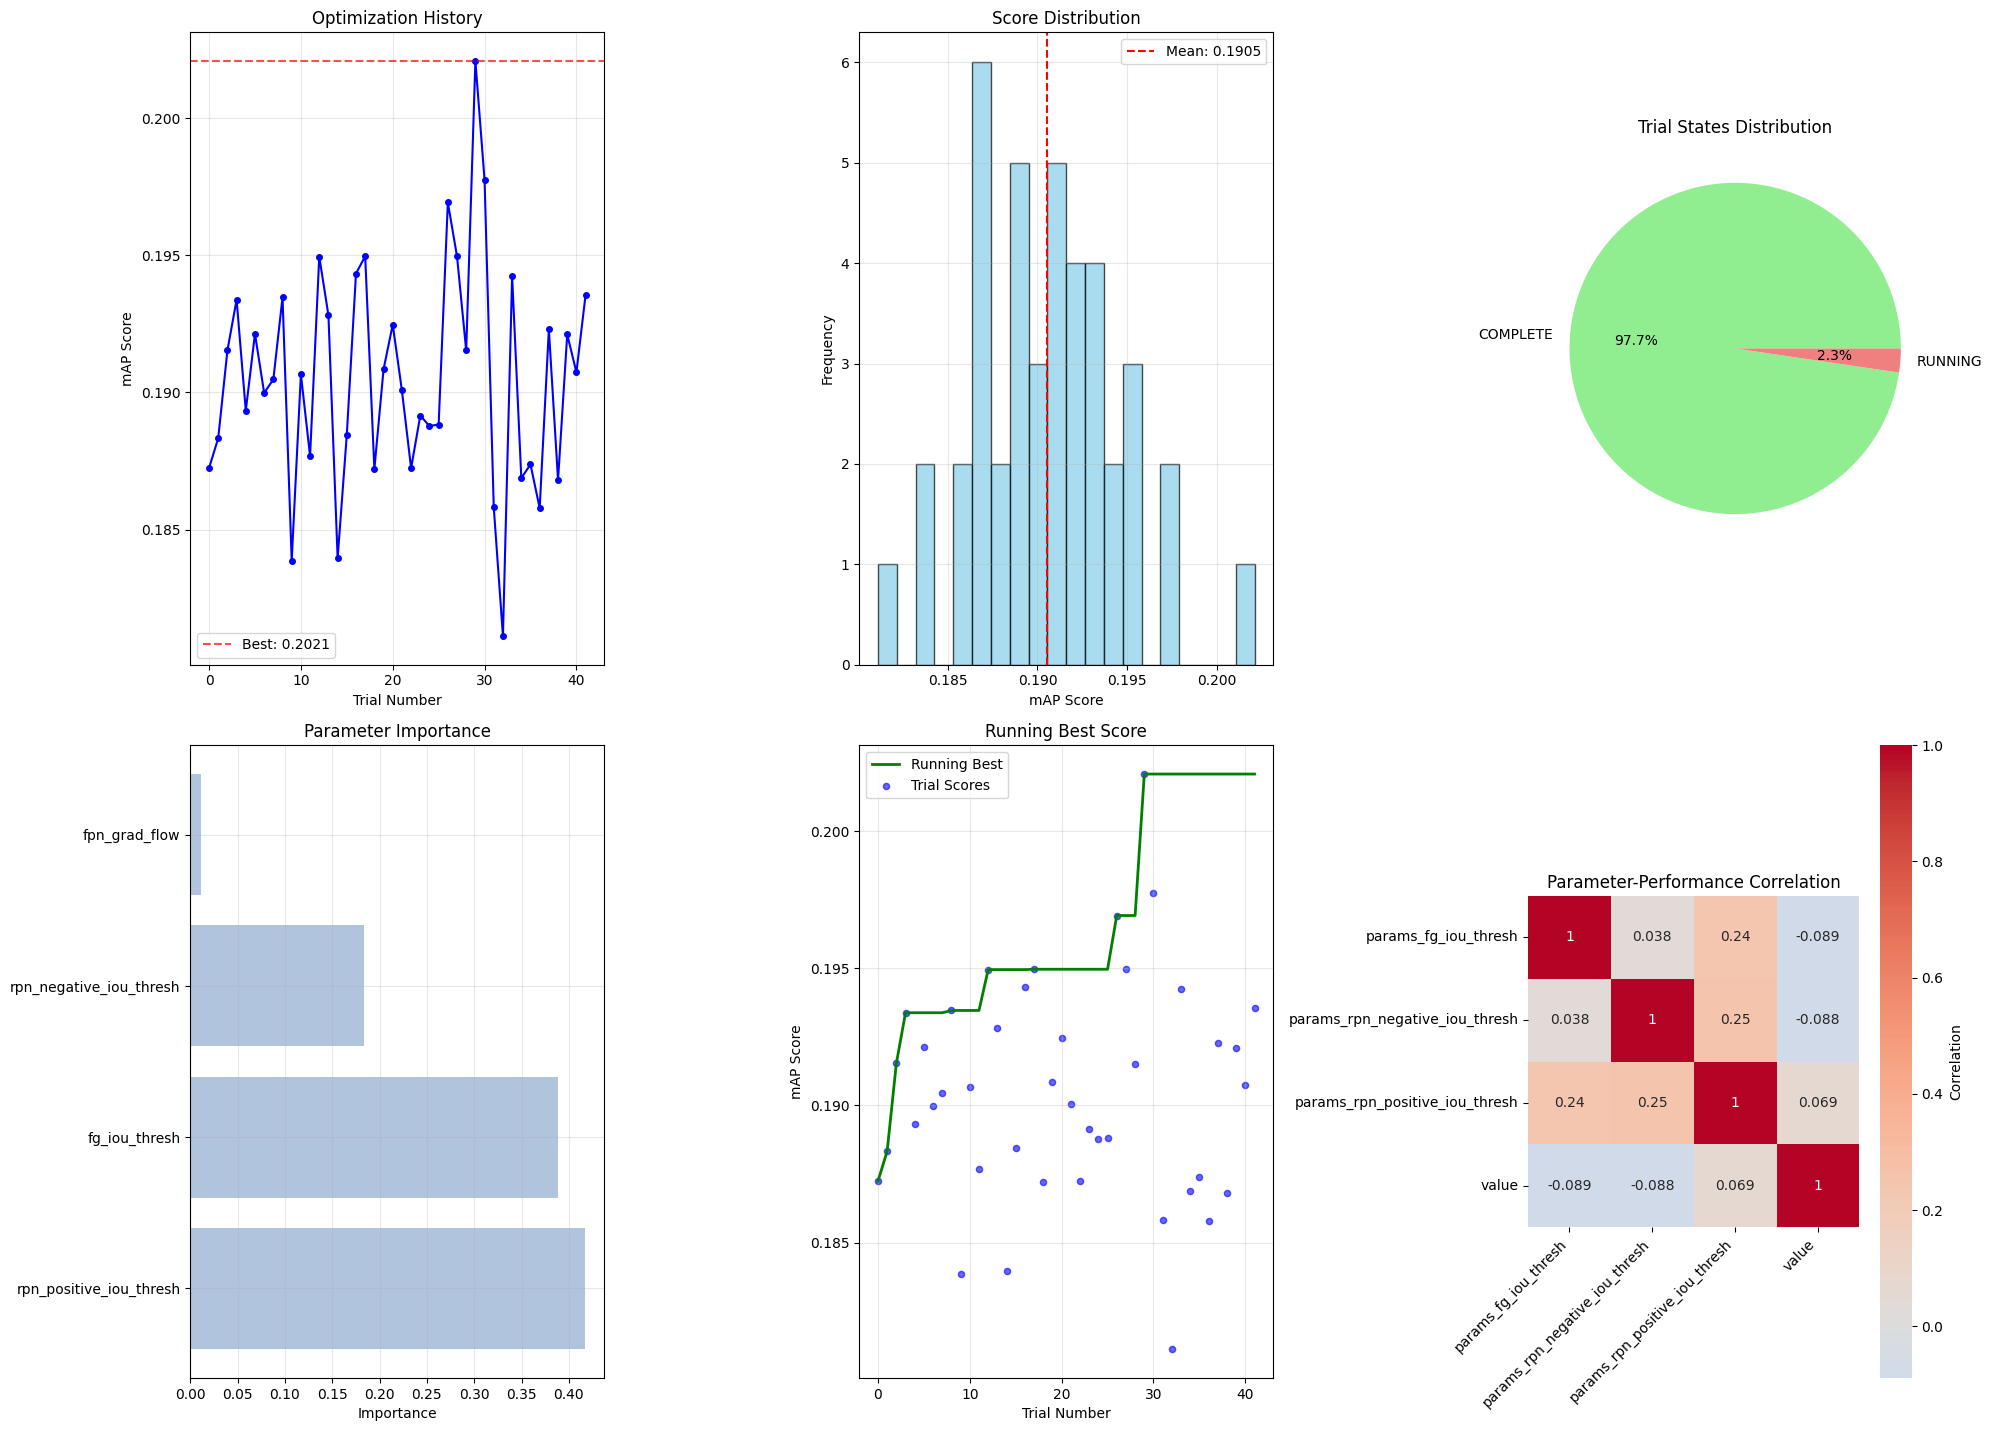


📋 DETAILED TRIAL STATISTICS:
Count:     42
Mean:      0.190526
Std:       0.004061
Min:       0.181124
25%:       0.187452
50%:       0.190565
75%:       0.193236
Max:       0.202079

💡 INSIGHTS:
   • Total improvement: 0.0210 mAP points
   • Study is still improving (recent trials performing better)

ANALYSIS COMPLETE


In [4]:
# Now analyzing the 41 trials that we have run to find the best hyperparameters and their importance.
study_save_path  = '/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/optuna_study.db'
study = optuna.create_study(direction="maximize",storage=f"sqlite:///{study_save_path}",study_name="trial",load_if_exists=True)

# We already done 42 trials below we are showing analytics the our Optuna study.
analyze_optuna_study(study)


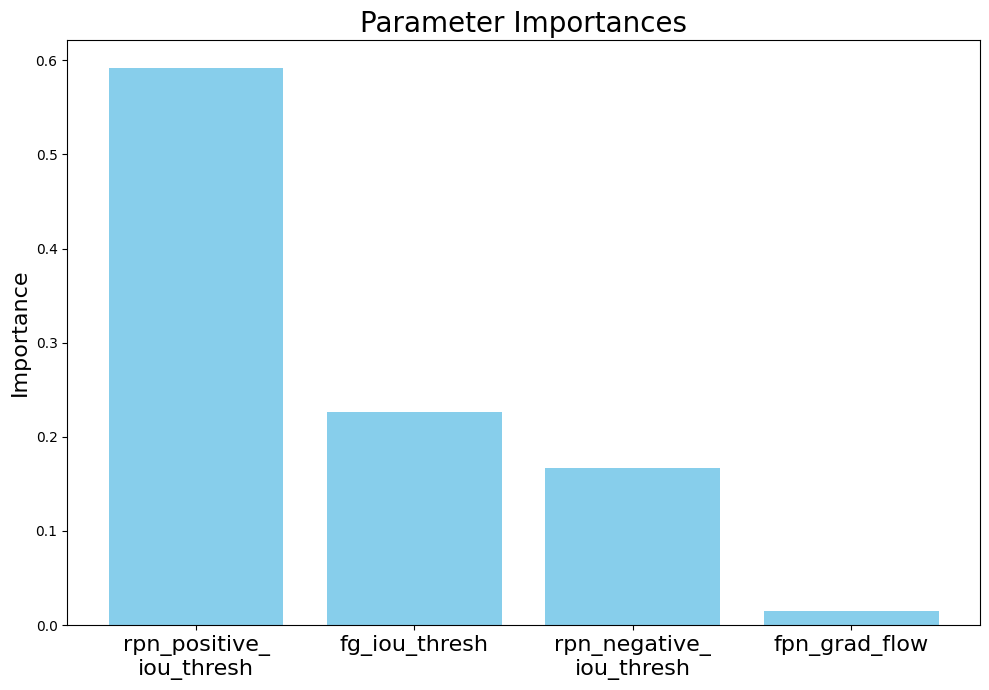

In [20]:
import matplotlib.pyplot as plt
from optuna.importance import get_param_importances
import textwrap

# Assume you have a completed study
# study = ...

# Get parameter importances
importances = get_param_importances(study)

# Wrap long parameter names for readability
labels = [ "\n".join(textwrap.wrap(name, 13)) for name in importances.keys() ]

# Vertical bar plot with better label readability
fig, ax = plt.subplots(figsize=(10, 7))  # narrow width, taller height
ax.bar(labels, importances.values(), color='skyblue')
ax.set_ylabel("Importance", fontsize=16)
ax.set_title("Parameter Importances", fontsize=20)
ax.tick_params(axis='x', labelsize=16)

plt.xticks(rotation=0)  # 0 rotation since wrapped text is vertical
plt.tight_layout()
plt.show()

In [ ]:

from optuna.visualization import plot_slice
fig = plot_slice(study)
fig.show()

Linear correlation analysis didn't reveal a singificant correlation between study hyperparameters and validation set mAP. This makes sense that relationship between thresholds and mAP is usually non-linear (similar to a parabole with a maximum at the optimal values). Fanova tests will evaluate if such a relationship exists.

In [ ]:
# Create Fanova evaluator

evaluator = FanovaImportanceEvaluator()

# Compute importance
importance_dict = evaluator.evaluate(study)

# Print importance per hyperparameter
for param, importance in importance_dict.items():
    print(f"{param}: {importance:.4f}")

# There is a non-trivial interaction between hyparparameters and mAP as hinted by the results below.

rpn_positive_iou_thresh: 0.2931
fg_iou_thresh: 0.2625
rpn_negative_iou_thresh: 0.1090
fpn_grad_flow: 0.0085


In [ ]:
# The best parameters according to your study.
study.best_params

{'fg_iou_thresh': 0.41540913959701997,
 'rpn_positive_iou_thresh': 0.7889436011290939,
 'rpn_negative_iou_thresh': 0.21978901610088492,
 'fpn_grad_flow': True}

In [ ]:
# Now training for stage 2 using the best hyperparameter configuration

# Loading model from stage 1 again.
model_stage_2_tuned = load_model_correctly(path_stage_1,num_classes=20,load_heads=False,freeze_backbone=True)
model_stage_2_checkpoint_path = '/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_2_tuned_checkpoints'

#Setting the best hyperparameters and the optimal anchor sizes.
best_anchor_sizes = ((31,), (73,), (131,), (210,), (330,))
best_aspect_ratios = ((0.5, 1.2, 1.7),) * len(best_anchor_sizes)
anchor_generator = AnchorGenerator(sizes=best_anchor_sizes, aspect_ratios=best_aspect_ratios)
model_stage_2_tuned.rpn.anchor_generator = anchor_generator

model_stage_2_tuned.roi_heads.fg_iou_thresh = 0.415409
model_stage_2_tuned.roi_heads.bg_iou_thresh = 0.415409 * 0.5
model_stage_2_tuned.rpn.positive_iou_thresh = 0.7889
model_stage_2_tuned.rpn.negative_iou_thresh = 0.2197

# No updates for FPN for faster training.
for param in model_stage_2_tuned.backbone.fpn.parameters():
    param.requires_grad = False

# Using a mild weight decay.
optimizer_stage_2  = torch.optim.AdamW(model_stage_2_tuned.parameters(), lr=1e-4, weight_decay=1e-4)

tuning_hyperparams_dict_stage_2 = {
    "alpha": 0.9,                 # balances normal loss vs GIoU loss
    "iou_threshold": 0.45,              # standard for box matching
    "max_epochs": 10,                   # enough for convergence
    "patience": 5,                      # patience equals to training epochs - no early stopping used
    "root_path": partitioned_data_root_path,
    "train_partitions": 8,
    "val_partitions": [False, True, False, False],
    "batch_size": 4,                    # GPU memory safe
    "num_workers": 0,                   # parallel loading
    "cosine_t_max": 10,                 # cosine scheduler max epochs (same as max_epochs)
    "cosine_eta_min": 1e-5,             # minimum learning rate for cosine scheduler
    "cosine_last_epoch": -1,            # starting epoch for cosine scheduler
    "use_wandb": False,                 # not used
    "pruning": False,                   # not used
    "trial": None,                      # not used
    "checkpoint_save_path": model_stage_2_checkpoint_path,
    "load_checkpoint": None,
    "validate_only_last":False
}

val_losses_stage_2_tuned, train_losses_stage_2_tuned, val_maps_stage_2_tuned = train_epoch_alpha_mixed_precision(
    model=model_stage_2_tuned, optimizer=optimizer_stage_2, device=device, **tuning_hyperparams_dict_stage_2
)




Now we unfreeze all of the weights, lower the learning rate and tuned the network for 2 additional epochs to squeeze out the last 2 mAp :) This additional tuning exploits the 2 validation partitons that we used to monitor during the hyperparameter tuning and stage 2 training. Since we will evaluate our final test scores on the last 2 partitions that weren't involved at all there is little risk of data leakage.

In [ ]:
# New training hyperparameters for stage 3

stage_3_checkpoint_path = '/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_3_tuned_checkpoints'
tuning_hyperparams_dict_stage_3 = {
    "alpha": 0.9,                 # balances normal loss vs GIoU loss
    "iou_threshold": 0.45,              # standard for box matching
    "max_epochs": 2,                   # enough for convergence (we will)
    "patience": 5,                      # patience equals to training epochs - no early stopping used
    "root_path": partitioned_data_root_path,
    "train_partitions": 2,
    "val_partitions": [False, False, True, False],
    "batch_size": 4,                    # GPU memory safe
    "num_workers": 0,                   # parallel loading
    "cosine_t_max": 4,                 # cosine scheduler max epochs (same as max_epochs)
    "cosine_eta_min": 1e-5,             # minimum learning rate for cosine scheduler
    "cosine_last_epoch": -1,            # starting epoch for cosine scheduler
    "use_wandb": False,                 # not used
    "pruning": False,                   # not used
    "trial": None,                      # not used
    "checkpoint_save_path": "/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_3_tuned_checkpoints_2",
    "load_checkpoint": None,
    "validate_only_last":False,
     "extra_training": True # Extra trainin enabled
}

# Starging from the stage2 trainined model
path_stage_3_tuned = '/content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_2_trained.pth'
model_stage_3_tuned = load_model_correctly(path_stage_3_tuned,num_classes=20,load_heads=True,freeze_backbone=False)

#Unfreezing FPN too.
for param in model_stage_3_tuned.backbone.fpn.parameters():
    param.requires_grad = True

# Same hyperparameters
best_anchor_sizes = ((31,), (73,), (131,), (210,), (330,))
best_aspect_ratios = ((0.5, 1.2, 1.7),) * len(best_anchor_sizes)
anchor_generator = AnchorGenerator(sizes=best_anchor_sizes, aspect_ratios=best_aspect_ratios)
model_stage_3_tuned.rpn.anchor_generator = anchor_generator

model_stage_3_tuned.roi_heads.fg_iou_thresh = 0.415409
model_stage_3_tuned.roi_heads.bg_iou_thresh = 0.415409 * 0.5
model_stage_3_tuned.rpn.positive_iou_thresh = 0.7889
model_stage_3_tuned.rpn.negative_iou_thresh = 0.2197

# Wrap optimizer creation in autocast
# Learning rate is 10 time smaller to not overfit.
with torch.cuda.amp.autocast():
    optimizer_stage_3  = torch.optim.AdamW(model_stage_3_tuned.parameters(), lr=1e-4/10, weight_decay=0)

val_losses_stage_3_tuned, train_losses_stage_3_tuned, val_maps_stage_3_tuned = train_epoch_alpha_mixed_precision(
    model=model_stage_3_tuned, optimizer=optimizer_stage_3, device=device, **tuning_hyperparams_dict_stage_3
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-2081086088.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-3798805874.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


[Epoch 1/4] Starting training...
Extra training activated.
[Extra_training_from_val_set] Partition 1 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Extra_training_from_val_set Loader] Partition 1 - 125 samples


Training epoch 1 partition 1:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipython-input-3798805874.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training epoch 1 partition 1: 100%|██████████| 32/32 [01:08<00:00,  2.13s/it]


[Extra_training_from_val_set] Partition 2 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Extra_training_from_val_set Loader] Partition 2 - 125 samples


Training epoch 1 partition 2: 100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


[Epoch 1] Avg Train Loss: 1.2076
[Val] Partition 3 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Val Loader] Partition 3 - 125 samples


Validating epoch 1 partition 3:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipython-input-3798805874.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it]


[Epoch 1] Overall mAP (last val partition 3): 0.2833
[Epoch 1] Avg Val Loss: 1.1511
[Info] Validation loss improved. Resetting patience counter.
[Epoch 1] Cosine LR: 0.000010

[Epoch 2/4] Starting training...
Extra training activated.
[Extra_training_from_val_set] Partition 1 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Extra_training_from_val_set Loader] Partition 1 - 125 samples


Training epoch 2 partition 1: 100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


[Extra_training_from_val_set] Partition 2 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Extra_training_from_val_set Loader] Partition 2 - 125 samples


Training epoch 2 partition 2: 100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


[Epoch 2] Avg Train Loss: 1.0758
[Val] Partition 3 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Val Loader] Partition 3 - 125 samples


Evaluating: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it]


[Epoch 2] Overall mAP (last val partition 3): 0.2875
[Epoch 2] Avg Val Loss: 1.1394
[Info] Validation loss improved. Resetting patience counter.
[Epoch 2] Cosine LR: 0.000010
[Checkpoint] Saved checkpoint to /content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_3_tuned_checkpoints_2/checkpoint_epoch_2.pth

[Epoch 3/4] Starting training...
Extra training activated.
[Extra_training_from_val_set] Partition 1 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Extra_training_from_val_set Loader] Partition 1 - 125 samples


Training epoch 3 partition 1: 100%|██████████| 32/32 [01:18<00:00,  2.46s/it]


[Extra_training_from_val_set] Partition 2 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Extra_training_from_val_set Loader] Partition 2 - 125 samples


Training epoch 3 partition 2: 100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


[Epoch 3] Avg Train Loss: 1.0153
[Val] Partition 3 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Val Loader] Partition 3 - 125 samples


Evaluating: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it]


[Epoch 3] Overall mAP (last val partition 3): 0.2844
[Epoch 3] Avg Val Loss: 1.1651
[Info] Validation loss did not improve enough. Patience: 1/5
[Epoch 3] Cosine LR: 0.000010

[Epoch 4/4] Starting training...
Extra training activated.
[Extra_training_from_val_set] Partition 1 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Extra_training_from_val_set Loader] Partition 1 - 125 samples


Training epoch 4 partition 1: 100%|██████████| 32/32 [01:06<00:00,  2.09s/it]


[Extra_training_from_val_set] Partition 2 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Extra_training_from_val_set Loader] Partition 2 - 125 samples


Training epoch 4 partition 2: 100%|██████████| 32/32 [01:08<00:00,  2.14s/it]


[Epoch 4] Avg Train Loss: 0.9618
[Val] Partition 3 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Val Loader] Partition 3 - 125 samples


Evaluating: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it]


[Epoch 4] Overall mAP (last val partition 3): 0.2885
[Epoch 4] Avg Val Loss: 1.1717
[Info] Validation loss did not improve enough. Patience: 2/5
[Epoch 4] Cosine LR: 0.000010
[Checkpoint] Saved checkpoint to /content/drive/MyDrive/Vision Project/for_github/training_stage_1_2_and_3/checkpoint_files/stage_3_tuned_checkpoints_2/checkpoint_epoch_4.pth


Learning curves for training stage 2 and 3.

The full performance measurements on the test set.

In [ ]:
val_loaders,val_datasets = load_data_loaders_and_datasets("val",partitions=4,batch_size=8, root_path=partitioned_data_root_path)


[Val] Partition 1 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Val] Partition 2 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Val] Partition 3 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Val] Partition 4 - Images: torch.Size([125, 3, 1024, 2048]), Annotations: torch.Size([125, 1024, 2048])
[Val Loader] Partition 1 - 125 samples
[Val Loader] Partition 2 - 125 samples
[Val Loader] Partition 3 - 125 samples
[Val Loader] Partition 4 - 125 samples


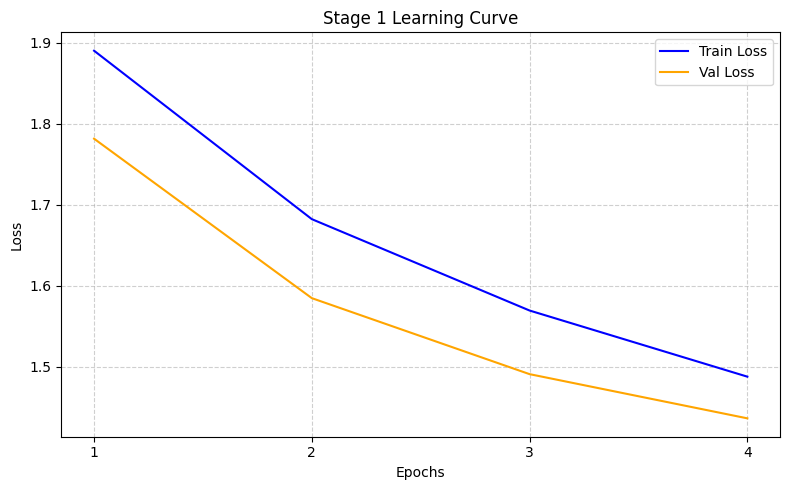

Evaluating: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it]



===== Evaluation Results =====
mAP @ IoU=0.50:0.95 : 0.2706
mAP @ IoU=0.50    : 0.5081
mAP @ IoU=0.75    : 0.2507
mAR @ 100         : 0.3767
Avg IoU (Hungarian)  : 0.7730
Avg GIoU (Hungarian) : 0.7664

--- Per-Class Metrics ---
Class 0 (person): AP=0.2759, AR@100=0.3687
Class 1 (rider): AP=0.3130, AR@100=0.4406
Class 2 (car): AP=0.4738, AR@100=0.5339
Class 3 (truck): AP=0.1186, AR@100=0.2550
Class 4 (bus): AP=0.4208, AR@100=0.5512
Class 5 (train): AP=-1.0000, AR@100=-1.0000
Class 6 (motorcycle): AP=0.0958, AR@100=0.1945
Class 7 (bicycle): AP=0.1960, AR@100=0.2930



Evaluating: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it]


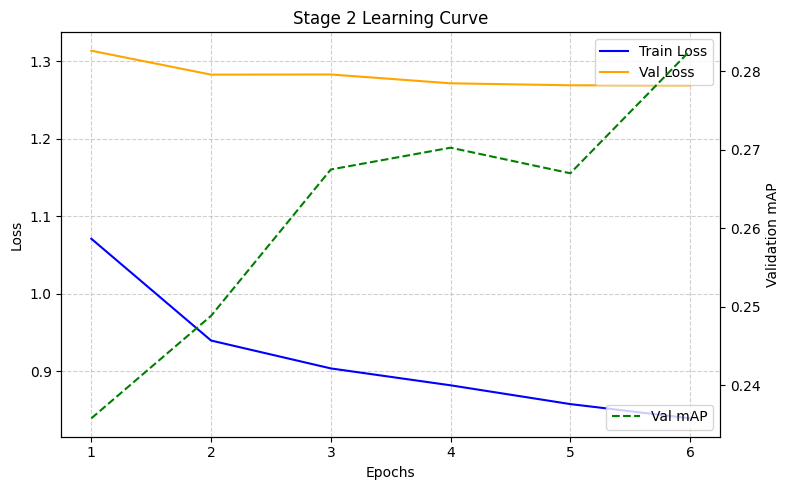

Evaluating: 100%|██████████| 16/16 [00:37<00:00,  2.32s/it]



===== Evaluation Results =====
mAP @ IoU=0.50:0.95 : 0.2751
mAP @ IoU=0.50    : 0.5037
mAP @ IoU=0.75    : 0.2691
mAR @ 100         : 0.3838
Avg IoU (Hungarian)  : 0.7772
Avg GIoU (Hungarian) : 0.7710

--- Per-Class Metrics ---
Class 0 (person): AP=0.2823, AR@100=0.3740
Class 1 (rider): AP=0.3203, AR@100=0.4385
Class 2 (car): AP=0.4816, AR@100=0.5349
Class 3 (truck): AP=0.1241, AR@100=0.2750
Class 4 (bus): AP=0.4009, AR@100=0.5302
Class 5 (train): AP=-1.0000, AR@100=-1.0000
Class 6 (motorcycle): AP=0.1085, AR@100=0.2364
Class 7 (bicycle): AP=0.2080, AR@100=0.2973



Evaluating: 100%|██████████| 16/16 [00:37<00:00,  2.32s/it]


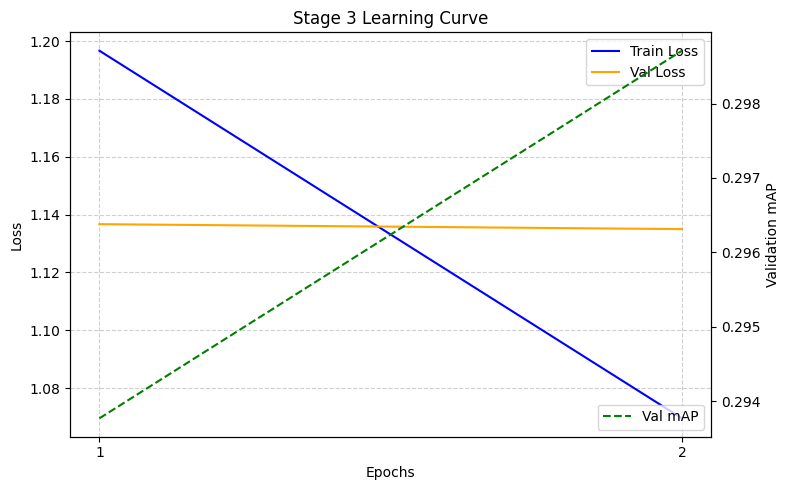

Evaluating: 100%|██████████| 16/16 [00:37<00:00,  2.36s/it]



===== Evaluation Results =====
mAP @ IoU=0.50:0.95 : 0.2978
mAP @ IoU=0.50    : 0.5290
mAP @ IoU=0.75    : 0.2921
mAR @ 100         : 0.4020
Avg IoU (Hungarian)  : 0.7808
Avg GIoU (Hungarian) : 0.7747

--- Per-Class Metrics ---
Class 0 (person): AP=0.2881, AR@100=0.3742
Class 1 (rider): AP=0.3588, AR@100=0.4820
Class 2 (car): AP=0.4922, AR@100=0.5471
Class 3 (truck): AP=0.1434, AR@100=0.2467
Class 4 (bus): AP=0.4159, AR@100=0.5628
Class 5 (train): AP=-1.0000, AR@100=-1.0000
Class 6 (motorcycle): AP=0.1649, AR@100=0.2818
Class 7 (bicycle): AP=0.2213, AR@100=0.3191



Evaluating: 100%|██████████| 16/16 [00:37<00:00,  2.36s/it]


In [ ]:
model_stage_1 = load_model_correctly(path_stage_1, num_classes=20, load_heads=True, freeze_backbone=True)
plot_learning_curves(path_stage_1, name="Stage 1 Learning Curve",legacy_checkpoint=True)
evaluate_test_set(model_stage_1, val_loaders[2:4], device, iou_threshold=0.5)
map_results_1 = evaluate_map_extended_hungarian(model_stage_1, val_loaders[2:4], device, iou_threshold=0.5)
del model_stage_1
torch.cuda.empty_cache()

model_stage_2 = load_model_correctly(path_stage_2, num_classes=20, load_heads=True, freeze_backbone=True)
plot_learning_curves(path_stage_2, name="Stage 2 Learning Curve")
evaluate_test_set(model_stage_2, val_loaders[2:4], device, iou_threshold=0.5)
map_results_2 = evaluate_map_extended_hungarian(model_stage_2, val_loaders[2:4], device, iou_threshold=0.5)
del model_stage_2
torch.cuda.empty_cache()

model_stage_3 = load_model_correctly(path_stage_3, num_classes=20, load_heads=True, freeze_backbone=True)
plot_learning_curves(path_stage_3, name="Stage 3 Learning Curve")
evaluate_test_set(model_stage_3, val_loaders[2:4], device, iou_threshold=0.5)
map_results_3= evaluate_map_extended_hungarian(model_stage_3, val_loaders[2:4], device, iou_threshold=0.5)
del model_stage_3
torch.cuda.empty_cache()

In [ ]:
map_results_1

{'map': tensor(0.2706),
 'map_50': tensor(0.5081),
 'map_75': tensor(0.2507),
 'map_small': tensor(0.0497),
 'map_medium': tensor(0.2063),
 'map_large': tensor(0.4690),
 'mar_1': tensor(0.1670),
 'mar_10': tensor(0.3479),
 'mar_100': tensor(0.3767),
 'mar_small': tensor(0.1438),
 'mar_medium': tensor(0.3263),
 'mar_large': tensor(0.5754),
 'map_per_class': tensor([ 0.2759,  0.3130,  0.4738,  0.1186,  0.4208, -1.0000,  0.0958,  0.1960]),
 'mar_100_per_class': tensor([ 0.3687,  0.4406,  0.5339,  0.2550,  0.5512, -1.0000,  0.1945,  0.2930]),
 'classes': tensor([12, 13, 14, 15, 16, 17, 18, 19], dtype=torch.int32),
 'avg_iou': 0.773025422586913,
 'avg_giou': 0.7664430496442195}

In [ ]:
map_results_2

{'map': tensor(0.2751),
 'map_50': tensor(0.5037),
 'map_75': tensor(0.2691),
 'map_small': tensor(0.0360),
 'map_medium': tensor(0.2183),
 'map_large': tensor(0.4665),
 'mar_1': tensor(0.1739),
 'mar_10': tensor(0.3554),
 'mar_100': tensor(0.3838),
 'mar_small': tensor(0.0820),
 'mar_medium': tensor(0.3377),
 'mar_large': tensor(0.5761),
 'map_per_class': tensor([ 0.2823,  0.3203,  0.4816,  0.1241,  0.4009, -1.0000,  0.1085,  0.2080]),
 'mar_100_per_class': tensor([ 0.3740,  0.4385,  0.5349,  0.2750,  0.5302, -1.0000,  0.2364,  0.2973]),
 'classes': tensor([12, 13, 14, 15, 16, 17, 18, 19], dtype=torch.int32),
 'avg_iou': 0.7771843690597625,
 'avg_giou': 0.7709832997061312}

In [ ]:
map_results_3

{'map': tensor(0.2978),
 'map_50': tensor(0.5290),
 'map_75': tensor(0.2921),
 'map_small': tensor(0.0950),
 'map_medium': tensor(0.2352),
 'map_large': tensor(0.5033),
 'mar_1': tensor(0.1908),
 'mar_10': tensor(0.3744),
 'mar_100': tensor(0.4020),
 'mar_small': tensor(0.1492),
 'mar_medium': tensor(0.3494),
 'mar_large': tensor(0.6100),
 'map_per_class': tensor([ 0.2881,  0.3588,  0.4922,  0.1434,  0.4159, -1.0000,  0.1649,  0.2213]),
 'mar_100_per_class': tensor([ 0.3742,  0.4820,  0.5471,  0.2467,  0.5628, -1.0000,  0.2818,  0.3191]),
 'classes': tensor([12, 13, 14, 15, 16, 17, 18, 19], dtype=torch.int32),
 'avg_iou': 0.7807802033295795,
 'avg_giou': 0.7746745465054216}

Some example inferences from the fully trained model.

In [ ]:
model_stage_3 = load_model_correctly(path_stage_3, num_classes=20, load_heads=True, freeze_backbone=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


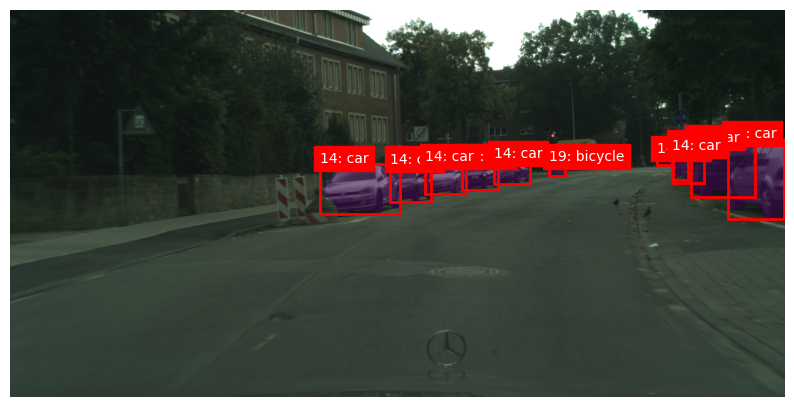

In [ ]:
prediction, image_tensor = run_inference(model_stage_3,val_datasets[2]  , 112, device='cuda')
visualize_prediction(image_tensor, prediction, score_threshold=0.75)

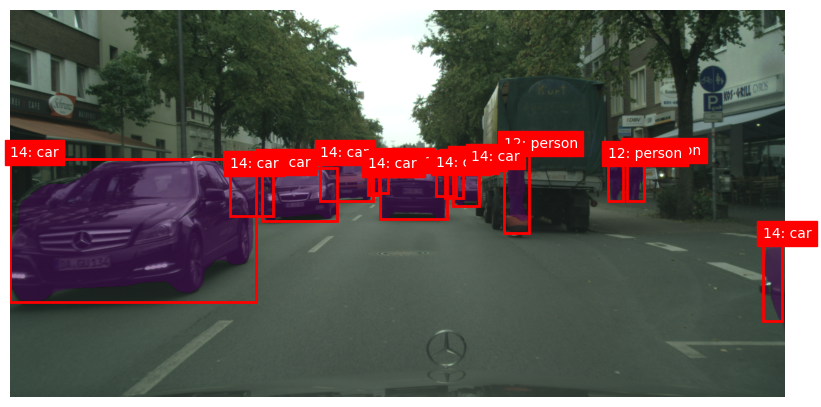

In [ ]:
prediction, image_tensor = run_inference(model_stage_3,val_datasets[3]  , 39, device='cuda')
visualize_prediction(image_tensor, prediction, score_threshold=0.75)

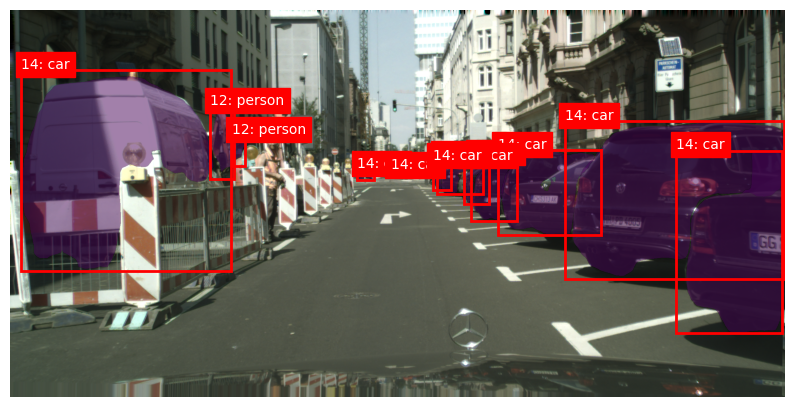

In [ ]:
prediction, image_tensor = run_inference(model_stage_3,val_datasets[2]  , 3, device='cuda')
visualize_prediction(image_tensor, prediction, score_threshold=0.75)